In [79]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-recruiting-trip-type-classification/train.csv.zip
/kaggle/input/walmart-recruiting-trip-type-classification/sample_submission.csv.zip
/kaggle/input/walmart-recruiting-trip-type-classification/test.csv.zip


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss,accuracy_score
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder

In [81]:
data=pd.read_csv('../input/walmart-recruiting-trip-type-classification/train.csv.zip')
data.head(5)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


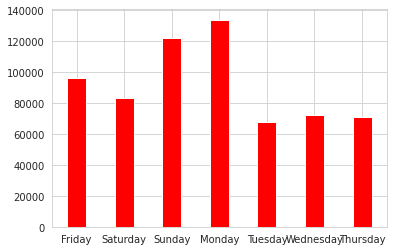

In [82]:
description=data['DepartmentDescription'].unique()###storing the different dept lists
weekday_grouping=data.groupby(['Weekday']).count()#storing the different days of the week
y_axis=weekday_grouping.loc[:,'TripType']
x_axis=data['Weekday'].unique()
#print(weekday_grouping)
#print(weekday.shape)
plt.bar(x_axis,y_axis,color ='red',width = 0.4)
plt.show()

clearly the sales is high on the weekends and interestly on monday.

In [83]:
Trip_type=data.groupby(['TripType']).count()
print(Trip_type)

          VisitNumber  Weekday     Upc  ScanCount  DepartmentDescription  \
TripType                                                                   
3                6827     6827    6822       6827                   6822   
4                 901      901     896        901                    900   
5               13836    13836   11253      13836                  13823   
6                3405     3405    3402       3405                   3402   
7               23199    23199   23168      23199                  23170   
8               22844    22844   22766      22844                  22776   
9               16820    16820   16738      16820                  16741   
12               2108     2108    2104       2108                   2104   
14                 35       35      35         35                     35   
15               7147     7147    7126       7147                   7126   
18               2977     2977    2971       2977                   2971   
19          

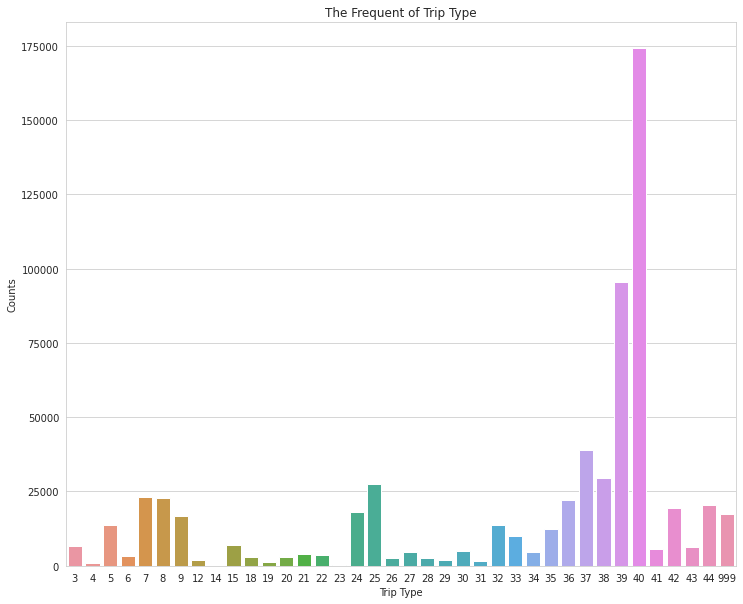

In [84]:
plt.figure(figsize = (12, 10))

sns.set_style('whitegrid')
ax = sns.countplot(x = 'TripType', data = data)
ax = ax.set(title = 'The Frequent of Trip Type', ylabel = 'Counts', xlabel = 'Trip Type')


clearly some triptype have more frequent visits

In [85]:
print(data.isnull().sum())###checking for void values in the dataframe
data.dtypes
data['FinelineNumber'].unique()

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64


array([1000., 8931., 4504., ..., 8257., 4314., 7130.])

In [86]:
data.loc[:,'DepartmentDescription'].fillna(value=999,inplace=True)
data.loc[:,'Upc'].fillna(value=0,inplace=True)
data.loc[:,'FinelineNumber'].fillna(value=0,inplace=True)
data.isnull().sum()


TripType                 0
VisitNumber              0
Weekday                  0
Upc                      0
ScanCount                0
DepartmentDescription    0
FinelineNumber           0
dtype: int64

In [87]:
df=pd.DataFrame()


In [88]:
df['Count of items']=data.groupby(['VisitNumber'])['Upc'].count()
df.head(5)

,Count of items
VisitNumber,
5,1
7,2
8,23
9,3
10,3


In [89]:
df['item_sum'] = data.groupby(['VisitNumber'])['ScanCount'].sum()
df.head(5)

,Count of items,item_sum
VisitNumber,,
5,1,-1
7,2,2
8,23,28
9,3,3
10,3,3


In [90]:
df = df.reset_index().merge(data[['TripType', 'VisitNumber', 'Weekday']].drop_duplicates(), on='VisitNumber')
df.head(5)

,VisitNumber,Count of items,item_sum,TripType,Weekday
0,5,1,-1,999,Friday
1,7,2,2,30,Friday
2,8,23,28,26,Friday
3,9,3,3,8,Friday
4,10,3,3,8,Friday


In [92]:
hot_encoding=pd.get_dummies(data,columns=['DepartmentDescription'])
hot_encoding.head(5)

,TripType,VisitNumber,Weekday,Upc,ScanCount,FinelineNumber,DepartmentDescription_999,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,...,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS
0,999,5,Friday,6.811315e+10,-1,1000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30,7,Friday,6.053882e+10,1,8931.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,30,7,Friday,7.410811e+09,1,4504.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,26,8,Friday,2.238404e+09,2,3565.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26,8,Friday,2.006614e+09,2,1017.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
hot_encoding=hot_encoding.groupby(['VisitNumber']).sum()
hot_encoding.head(5)

,TripType,Upc,ScanCount,FinelineNumber,DepartmentDescription_999,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,...,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,999,6.811315e+10,-1,1000.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,60,6.794963e+10,2,13435.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,598,4.259239e+11,28,58669.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,24,1.070088e+09,3,5719.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,24,1.700927e+10,3,10073.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
x=pd.merge(left=df,right=hot_encoding,on='VisitNumber')
x.head(5)

,VisitNumber,Count of items,item_sum,TripType_x,Weekday,TripType_y,Upc,ScanCount,FinelineNumber,DepartmentDescription_999,...,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS
0,5,1,-1,999,Friday,999,6.811315e+10,-1,1000.0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,2,2,30,Friday,60,6.794963e+10,2,13435.0,0,...,0,0,0,0,1,0,0,0,0,0
2,8,23,28,26,Friday,598,4.259239e+11,28,58669.0,1,...,0,0,0,0,0,0,0,0,0,0
3,9,3,3,8,Friday,24,1.070088e+09,3,5719.0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,3,3,8,Friday,24,1.700927e+10,3,10073.0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
x.drop(columns=['TripType_y','Upc'],inplace=True)
x.head(5)

,VisitNumber,Count of items,item_sum,TripType_x,Weekday,ScanCount,FinelineNumber,DepartmentDescription_999,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,...,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS
0,5,1,-1,999,Friday,-1,1000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,2,2,30,Friday,2,13435.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,8,23,28,26,Friday,28,58669.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,3,3,8,Friday,3,5719.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,3,3,8,Friday,3,10073.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [151]:
#label_encoding weekdays
label_encoder= preprocessing.LabelEncoder()
x['Weekday']=label_encoder.fit_transform(x['Weekday'])
x.head(5)

,VisitNumber,Count of items,item_sum,TripType_x,Weekday,ScanCount,FinelineNumber,DepartmentDescription_999,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,...,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS
0,5,1,-1,999,0,-1,1000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,2,2,30,0,2,13435.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,8,23,28,26,0,28,58669.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,3,3,8,0,3,5719.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,3,3,8,0,3,10073.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
x.dtypes

VisitNumber                                    int64
Count of items                                 int64
item_sum                                       int64
TripType_x                                     int64
Weekday                                        int64
                                               ...  
DepartmentDescription_SLEEPWEAR/FOUNDATIONS    uint8
DepartmentDescription_SPORTING GOODS           uint8
DepartmentDescription_SWIMWEAR/OUTERWEAR       uint8
DepartmentDescription_TOYS                     uint8
DepartmentDescription_WIRELESS                 uint8
Length: 76, dtype: object

In [135]:
#calculating correction between the different features
corr=x.corr()
corr.head(5)

,VisitNumber,Count of items,item_sum,TripType_x,Weekday,ScanCount,FinelineNumber,DepartmentDescription_999,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,...,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS
VisitNumber,1.000000,0.007223,0.004105,0.003623,0.067663,0.004105,0.011741,-0.011245,-0.003135,0.005142,...,-0.003863,0.002899,0.003948,-0.000896,0.006315,-0.006813,0.012825,0.019189,0.008717,0.002956
Count of items,0.007223,1.000000,0.967569,-0.143237,-0.020336,0.967569,0.958952,0.080263,-0.021929,0.049114,...,0.229238,0.015374,0.180556,0.031272,0.119971,0.093209,0.055125,0.030072,0.098110,-0.023157
item_sum,0.004105,0.967569,1.000000,-0.207154,-0.019185,1.000000,0.925972,0.070863,-0.020597,0.041626,...,0.217873,0.015876,0.173888,0.030298,0.107384,0.079958,0.050816,0.017359,0.088758,-0.026202
TripType_x,0.003623,-0.143237,-0.207154,1.000000,0.004886,-0.207154,-0.139676,0.035816,0.014713,-0.009839,...,-0.029925,-0.002626,-0.060213,-0.000302,-0.019794,-0.006171,-0.005616,0.018455,-0.015822,0.012075
Weekday,0.067663,-0.020336,-0.019185,0.004886,1.000000,-0.019185,-0.019355,-0.002233,0.006373,-0.001101,...,-0.003628,-0.001701,0.003261,-0.009460,-0.004689,-0.004735,-0.003459,-0.003800,-0.014239,0.000268


In [137]:
heat_map=corr.iloc[0:7,0:7]
heat_map.head(5)

,VisitNumber,Count of items,item_sum,TripType_x,Weekday,ScanCount,FinelineNumber
VisitNumber,1.000000,0.007223,0.004105,0.003623,0.067663,0.004105,0.011741
Count of items,0.007223,1.000000,0.967569,-0.143237,-0.020336,0.967569,0.958952
item_sum,0.004105,0.967569,1.000000,-0.207154,-0.019185,1.000000,0.925972
TripType_x,0.003623,-0.143237,-0.207154,1.000000,0.004886,-0.207154,-0.139676
Weekday,0.067663,-0.020336,-0.019185,0.004886,1.000000,-0.019185,-0.019355


<AxesSubplot:>

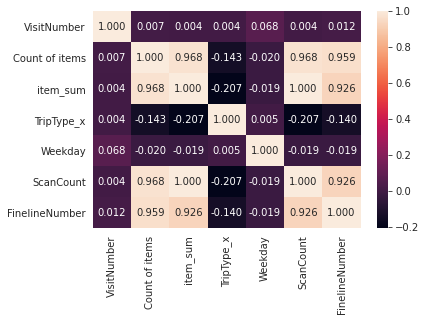

In [138]:
sns.heatmap(heat_map,annot=True,fmt='.3f')


Here visit Number doesnt correlate much with the trip type which is epected as it acts as a index ,also weekday has very less correlation with triptype,rest all the features correlates with the data.

In [139]:
y=x.loc[:,'TripType_x']
print(y)

0        999
1         30
2         26
3          8
4          8
        ... 
95669     25
95670     22
95671     39
95672     39
95673      8
Name: TripType_x, Length: 95674, dtype: int64


In [140]:
x.drop(columns=['VisitNumber','TripType_x','Weekday'],inplace=True)
x.head(5)

,Count of items,item_sum,ScanCount,FinelineNumber,DepartmentDescription_999,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,...,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS
0,1,-1,-1,1000.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2,2,13435.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,23,28,28,58669.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,3,5719.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,3,3,10073.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [148]:
x.dtypes

AttributeError: 'numpy.ndarray' object has no attribute 'dtypes'

In [127]:
print(type(x))

<class 'pandas.core.frame.DataFrame'>


In [144]:
from sklearn.preprocessing import StandardScaler  
st= StandardScaler()  
x= st.fit_transform(x)

In [163]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.2, random_state=0)  
print(type(x_train))
x_train.dtypes.loc['item_sum']

<class 'pandas.core.frame.DataFrame'>


dtype('int64')

In [172]:
from sklearn.linear_model import LogisticRegression
lg=LogisticRegression(max_iter=200,solver='liblinear')



In [176]:
lg.fit(x_train,y_train)


LogisticRegression(max_iter=200, solver='liblinear')

In [177]:
y_pred=lg.predict(x_test)


In [178]:
print(y_pred)

[39 40 39 ...  8  7 39]


In [186]:
pred = lg.predict_proba(x_test)
loss = log_loss(y_test,pred) 
print(loss)

2.190774342909927


In [189]:
accuray_lg=accuracy_score(y_pred,y_test)
print(accuray_lg)

0.4008361640972041


In [188]:
rfr=RandomForestRegressor()
rfr.fit(x_train,y_train)

RandomForestRegressor()

In [190]:
y_pred=rfr.predict(x_test)

In [196]:
for i in range(len(y_pred)):
    y_pred[i]=int(y_pred[i])

In [197]:
accuracy=accuracy_score(y_pred,y_test)
print(accuracy)

0.9998954794878495
